In [87]:
import pandas as pd
#dataset = pd.read_csv()

import zipfile
import os
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

#from google.colab import files


from glob import glob
from PIL import Image as pil_image
from matplotlib.pyplot import imshow, imsave
from IPython.display import Image as Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from glob import glob
from PIL import Image as pil_image
from matplotlib.pyplot import imshow, imsave
from IPython.display import Image as Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras
from keras.utils.np_utils import to_categorical

from keras.layers import concatenate

#from keras.utils import to_categorical

#Model imports
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation, Reshape, Lambda
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate, GlobalAveragePooling2D
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU, ReLU, Softmax
from keras.callbacks import *
from keras.layers.merge import concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model

In [89]:
print('Extracting Images into single directory')
os.mkdir('images4')

zip_ref = zipfile.ZipFile('/Users/kalebupatan/Documents/ML/Project/HAM10000_images_part_1.zip', 'r') #Replace your file path
zip_ref.extractall('images/')
zip_ref.close()
zip_ref = zipfile.ZipFile('/Users/kalebupatan/Documents/ML/Project/HAM10000_images_part_2.zip', 'r') #Replace your file path
zip_ref.extractall('images/')
zip_ref.close()
print("Done extracting")

Extracting Images into single directory
Done extracting


In [90]:
os.listdir()

['images',
 'Project.ipynb',
 'images1',
 'test.jpg',
 '.ipynb_checkpoints',
 'images4',
 'images3',
 '.git',
 'images2',
 'PROJECT PROPOSAL.pdf']

In [91]:
skin_dataset = pd.read_csv('/Users/kalebupatan/Documents/ML/Project/HAM10000_metadata.csv') #Replace your file path
skin_dataset

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


male       5406
female     4552
unknown      57
Name: sex, dtype: int64

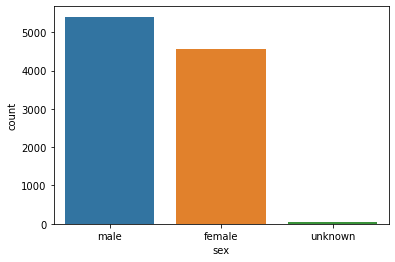

In [92]:
import seaborn as sb
skin_dataset['sex']
sb.countplot(x=skin_dataset['sex'])
skin_dataset['sex'].value_counts()

45.0    1299
50.0    1187
55.0    1009
40.0     985
60.0     803
70.0     756
35.0     753
65.0     731
75.0     618
30.0     464
80.0     404
85.0     290
25.0     247
20.0     169
5.0       86
15.0      77
10.0      41
0.0       39
Name: age, dtype: int64

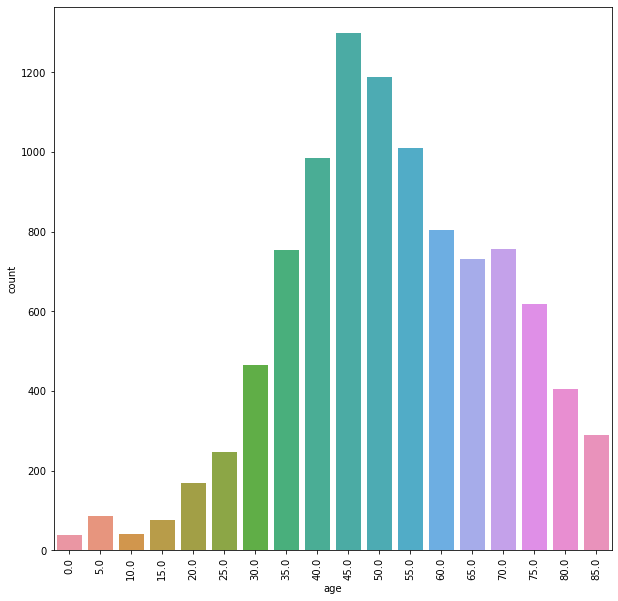

In [93]:
plt.figure(figsize=(10,10))
plt.xticks(rotation=90)
sb.countplot(x=skin_dataset['age'])
skin_dataset['age'].value_counts()

back               2192
lower extremity    2077
trunk              1404
upper extremity    1118
abdomen            1022
face                745
chest               407
foot                319
unknown             234
neck                168
scalp               128
hand                 90
ear                  56
genital              48
acral                 7
Name: localization, dtype: int64

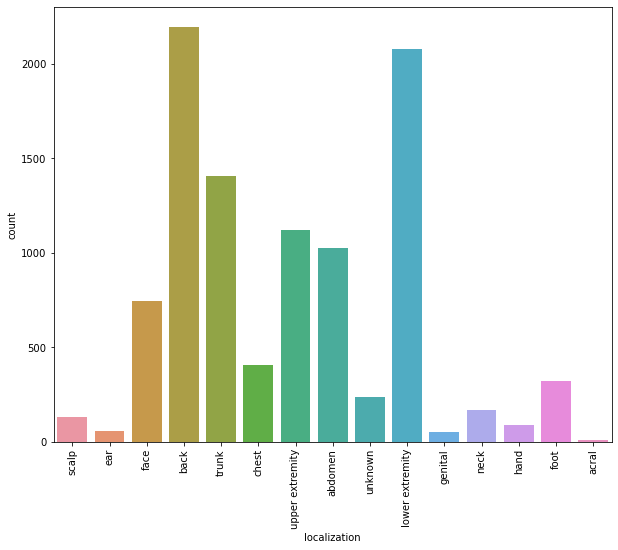

In [94]:
plt.figure(figsize=(10,8))
sb.countplot(x=skin_dataset['localization'])
plt.xticks(rotation=90)
skin_dataset['localization'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

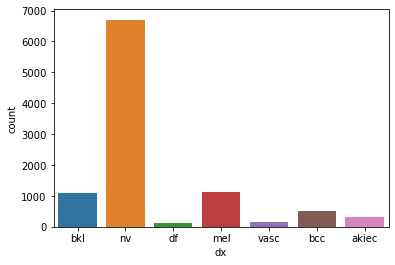

In [95]:
sb.countplot(x=skin_dataset['dx'])
skin_dataset['dx'].value_counts()

In [96]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

lesion_classes_dict = {
    0:'nv',
    1:'mel',
    2:'bkl',
    3:'bcc',
    4:'akiec',
    5:'vasc',
    6:'df'
}

skin_dataset['cell_type'] = skin_dataset['dx'].map(lesion_type_dict)

In [97]:
skin_dataset['cell_type_idx'] = pd.Categorical(skin_dataset['cell_type']).codes

In [98]:
skin_dataset.isna().sum().sort_values(ascending=False)

age              57
lesion_id         0
image_id          0
dx                0
dx_type           0
sex               0
localization      0
cell_type         0
cell_type_idx     0
dtype: int64

In [99]:
print(skin_dataset['age'].mean())
print(skin_dataset['age'].median())

51.863828077927295
50.0


In [100]:
skin_dataset['age'].fillna(skin_dataset['age'].mean(),inplace=True)

<Axes: xlabel='age', ylabel='Density'>

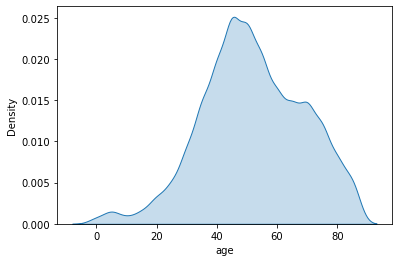

In [101]:
sb.kdeplot(skin_dataset['age'],fill=True)

In [102]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join('', '*', '*.jpg'))}

In [103]:
skin_dataset['path'] = skin_dataset['image_id'].map(image_path.get)
skin_dataset.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,images/ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,images/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,images/ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,images/ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2,images/ISIC_0031633.jpg


In [104]:
image_example = np.asarray(pil_image.open(skin_dataset['path'][0]))

image_example.shape

(450, 600, 3)

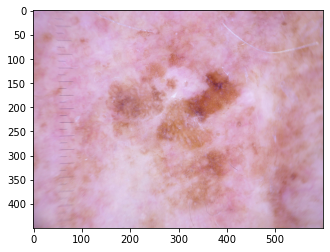

In [105]:
plt.imshow(image_example)

In [106]:
skin_dataset['image'] = skin_dataset['path'].map(lambda x: np.asarray(pil_image.open(x).resize((120,90))))


In [107]:
skin_dataset.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx,path,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,images/ISIC_0027419.jpg,"[[[190, 152, 194], [192, 155, 197], [191, 154,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,images/ISIC_0025030.jpg,"[[[24, 13, 22], [24, 14, 23], [24, 14, 26], [2..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,images/ISIC_0026769.jpg,"[[[185, 126, 135], [189, 133, 145], [192, 135,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,images/ISIC_0025661.jpg,"[[[24, 11, 17], [25, 11, 20], [31, 16, 27], [4..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2,images/ISIC_0031633.jpg,"[[[131, 89, 111], [143, 98, 121], [153, 108, 1..."


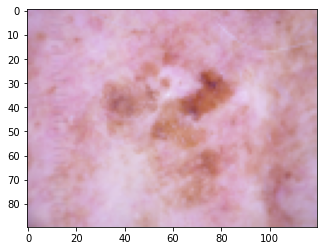

In [108]:
plt.imshow(skin_dataset['image'][0])

#### we can see that only a few of the features are dumped, however, almost all the features are sitll preserved

## Data preparation and modelling

In [109]:
features = skin_dataset.drop(['dx_type','localization','lesion_id'],axis=1)
features.head()


,image_id,dx,age,sex,cell_type,cell_type_idx,path,image
0,ISIC_0027419,bkl,80.0,male,Benign keratosis-like lesions,2,images/ISIC_0027419.jpg,"[[[190, 152, 194], [192, 155, 197], [191, 154,..."
1,ISIC_0025030,bkl,80.0,male,Benign keratosis-like lesions,2,images/ISIC_0025030.jpg,"[[[24, 13, 22], [24, 14, 23], [24, 14, 26], [2..."
2,ISIC_0026769,bkl,80.0,male,Benign keratosis-like lesions,2,images/ISIC_0026769.jpg,"[[[185, 126, 135], [189, 133, 145], [192, 135,..."
3,ISIC_0025661,bkl,80.0,male,Benign keratosis-like lesions,2,images/ISIC_0025661.jpg,"[[[24, 11, 17], [25, 11, 20], [31, 16, 27], [4..."
4,ISIC_0031633,bkl,75.0,male,Benign keratosis-like lesions,2,images/ISIC_0031633.jpg,"[[[131, 89, 111], [143, 98, 121], [153, 108, 1..."


In [211]:
lesion_classes_dict2 = {
    'nv':0,
    'mel':1,
    'bkl':2,
    'bcc':3,
    'akiec':4,
    'vasc':5,
    'df':6
}

target = skin_dataset['dx'].map(lesion_classes_dict2)

X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(features,target,test_size=0.01)


In [212]:
x_train = np.asarray(X_TRAIN['image'].tolist())
x_test = np.asarray(X_TEST['image'].tolist())

In [213]:
print(x_train.shape)
print(x_test.shape)

(9914, 90, 120, 3)
(101, 90, 120, 3)


In [214]:
train_mean = x_train.mean()
print(train_mean)
train_std = x_train.std()
print(train_std)
test_mean = x_test.mean()
print(test_mean)
test_std = x_test.std()
print(test_std)

159.7919125311008
46.45531134367002
162.28534714582568
46.276631388842766


In [215]:
x_train = (x_train-train_mean) / train_std
x_test = (x_test-test_mean) / test_std

In [216]:

print(Y_TRAIN.shape)
print(Y_TEST.shape)

(9914,)
(101,)


In [217]:
y_train = to_categorical(Y_TRAIN,num_classes=7)
y_test = to_categorical(Y_TEST,num_classes=7)

print(y_train.shape)
print(y_test.shape)

(9914, 7)
(101, 7)


In [218]:
X_train,X_val, Y_train,Y_val = train_test_split(x_train,y_train,test_size=0.15)

In [219]:
X_train  = X_train.reshape(X_train.shape[0],90,120,3)
x_test  = x_test.reshape(x_test.shape[0],90,120,3)
X_val  = X_val.reshape(X_val.shape[0],90,120,3)

print(X_train.shape)
print(x_test.shape)
print(X_val.shape)

(8426, 90, 120, 3)
(101, 90, 120, 3)
(1488, 90, 120, 3)


In [220]:
input_shape = (90, 120, 3)
num_classes = 7

model = Sequential()

model.add(Conv2D(32,kernel_size=(3, 3),activation='relu',name="conv1", input_shape=input_shape)) 
model.add(BatchNormalization(name="Norm1"))
model.add(Conv2D(64,kernel_size=(3, 3), activation='relu',name="Conv2")) 
model.add(BatchNormalization(name="Norm2"))
model.add(Conv2D(64,kernel_size=(3, 3), activation='relu',name="Conv3")) 
model.add(BatchNormalization(name="Norm3"))
model.add(MaxPooling2D(pool_size = (2, 2))) 
model.add(Dropout(0.20))

model.add(Conv2D(64, (3, 3), activation='relu',name="conv4")) 
model.add(BatchNormalization(name="Norm4"))
model.add(Conv2D(128, (3, 3), activation='relu',name="conv5")) 
model.add(BatchNormalization(name="Norm5"))
model.add(Conv2D(128, (3, 3), activation='relu',name="conv6")) 
model.add(BatchNormalization(name="Norm6"))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.20))

model.add(Conv2D(128, (3, 3), activation='relu',name="conv7")) 
model.add(BatchNormalization(name="Norm7"))
model.add(Conv2D(256, (3, 3), activation='relu',name="conv8")) 
model.add(BatchNormalization(name="Norm8"))
model.add(Conv2D(256, (3, 3), activation='relu',name="conv9")) 
model.add(BatchNormalization(name="Norm9"))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.20))

model.add(Conv2D(7,(1,1),name="conv10",activation="relu")) 
model.add(BatchNormalization(name="Norm10"))
model.add(Conv2D(7,kernel_size=(6,9),name="conv11"))
model.add(Flatten())
model.add(Activation('softmax'))

In [221]:
model.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

In [222]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.0001, 
                                            min_lr=0.000001)

In [223]:
#We can do later
#plot_model(model, to_file='simple_model_plot.png', show_shapes=True, show_layer_names=True)
#Image(retina=True, filename='simple_model_plot.png')

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.1 
)

epochs = 30
batch_size = 16
model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/30
198/526 [==========>...................] - ETA: 8:07 - loss: 1.1670 - accuracy: 0.6010

In [132]:
def plot_(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    f, [ax1, ax2] = plt.subplots(1,2, figsize=(15, 5))
    ax1.plot(range(len(acc)), acc, label="acc")
    ax1.plot(range(len(acc)), val_acc, label="val_acc")
    ax1.set_title("Training Accuracy vs Validation Accuracy")
    ax1.legend()

    ax2.plot(range(len(loss)), loss, label="loss")
    ax2.plot(range(len(loss)), val_loss, label="val_loss")
    ax2.set_title("Training Loss vs Validation Loss")
    ax2.legend()
    
    
plot_(model.history)

AttributeError: 'NoneType' object has no attribute 'history'

In [133]:
print("MAXIMUM ACCURACY OF SIMPLE SEQUENTIAL NETWORK is : ", round(max(model.history.history['val_acc'])*100,4))

AttributeError: 'NoneType' object has no attribute 'history'

Original Shape of image is :  (372, 662, 3)


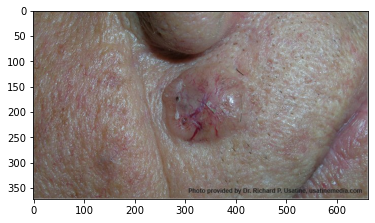

In [134]:
import urllib

url="https://www.cancer.org/content/dam/cancer-org/images/galleries/skin-cancer-images/cancer-basal-cell-carcinoma-01-restricted.jpg/jcr:content/renditions/cq5dam.web.1280.1280.jpeg"

urllib.request.urlretrieve(url,'test.jpg')
test_image = np.asarray(pil_image.open('test.jpg'))
print('Original Shape of image is : ',test_image.shape)
plt.imshow(test_image)

In [135]:
resized_image = np.asarray(pil_image.open('test.jpg').resize((120,90)))
image_array = np.asarray(resized_image.tolist())
test_image = image_array.reshape(1,90,120,3)

In [75]:
prediction_class = model.predict_classes(test_image)
print(prediction_class)
lesion_classes_dict[prediction_class[0]]

[3]


'bcc'